In [1]:
%matplotlib notebook

import pathlib
import sqlite3
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wms.dbs import weadbs, hdf5, pit
from wms.utils import periods
from wms.analysis import plots
import bchdf

Using bladecontrol plotting style.
Registering webvis-style.


In [2]:
weas = pit.query_pit("""
    SELECT WEA_Name, Datenbankname, Beginn_Datenspeicherung
    FROM VIEW_Windkraftanlagen
    WHERE WEA_Typ#Name = %s
        AND Datenbankname IS NOT NULL
        AND Sensor_Rotorblatt_1#Sensortyp#Bezeichnung = 'BCA423'""",
    ('Vestas V136/3450 Mk3B'))
weas = weas[~weas.Datenbankname.str.endswith('sim')].set_index('Datenbankname')

In [3]:
weas

,WEA_Name,Beginn_Datenspeicherung
Datenbankname,,
cmrblba_bc_t_02395,Vestas 217274,2017-09-06
cmrblba_bc_t_02476,Vestas 218547,2017-10-25
cmrblba_bc_t_02477,Vestas 218548,2017-10-24
cmrblba_bc_t_02491,Vestas 219368,2017-11-28
cmrblba_bc_t_02489,Vestas 219369,2017-11-27
cmrblba_bc_t_02490,Vestas 219370,2017-11-27
cmrblba_bc_t_02499,Vestas 219452,2017-12-11
cmrblba_bc_t_02503,Vestas 219447,2018-03-06
cmrblba_bc_t_02537,Vestas 219448,2018-03-07


In [4]:
def find_normal_periods(db, firstdata):
    tickets = pit.get_tickets_for_WEA(
        db, ['Beginn_am', 'Erstauftreten_des_Fehlers', 'Behebung_des_Fehlers',
             'Titel', 'Lösung', 'Lösungsklasse#Bezeichnung_DE', 'Geschlossen_am'])
    
    period = periods.TimeInterval(
        max(firstdata, pd.Timestamp('2019-03-12')), '2020-06-03')

    for _, ti in tickets.iterrows():
        start = (ti['Beginn_am'] if pd.isna(ti['Erstauftreten_des_Fehlers']) 
                 else ti['Erstauftreten_des_Fehlers'])
        if not pd.isna(ti['Behebung_des_Fehlers']):
            end = ti['Behebung_des_Fehlers']
        elif pd.isna(ti['Geschlossen_am']):
            end = pd.Timestamp.now()
        else:
            end = ti['Geschlossen_am']

        if end > start:
            period = period - periods.TimeInterval(start, end)
            
    return period

In [5]:
data_periods = pd.Series(dtype=object, index=weas.index)
for i, db in enumerate(weas.index):
    print(f"\r{' ' * 20}\r{i + 1:2d}/{weas.shape[0]}: {db}", end='', flush=True)
    data_periods[db] = find_normal_periods(
        db, weas.loc[db, 'Beginn_Datenspeicherung'])

51/51: cmrblba_bc_t_03004

In [23]:
opstate = {'temperature_mean': (8, 12), 
           'omega_mean': (0.11, 0.13)}

In [24]:
for db in weas.index:
    if data_periods[db]:
        weas.loc[db, 'N'] = weadbs.cdef_query(
            db, cycle='hour', columns=['COUNT(omega_mean)'], 
            where=dict(create_time=data_periods[db].aswhere, **opstate)).iloc[0, 0]
    else:
        weas.loc[db, 'N'] = 0
        
weas = weas.astype({'N': int})

u:\wms-python\wms\dbs\select.py:226: UserWarning: Discarding nonzero nanoseconds in conversion
  constraint = tuple(cfun(c) for c in constraint[:2])


In [25]:
weas

,WEA_Name,Beginn_Datenspeicherung,N
Datenbankname,,,
cmrblba_bc_t_02395,Vestas 217274,2017-09-06,585
cmrblba_bc_t_02476,Vestas 218547,2017-10-25,0
cmrblba_bc_t_02477,Vestas 218548,2017-10-24,40
cmrblba_bc_t_02491,Vestas 219368,2017-11-28,94
cmrblba_bc_t_02489,Vestas 219369,2017-11-27,0
cmrblba_bc_t_02490,Vestas 219370,2017-11-27,0
cmrblba_bc_t_02499,Vestas 219452,2017-12-11,0
cmrblba_bc_t_02503,Vestas 219447,2018-03-06,0
cmrblba_bc_t_02537,Vestas 219448,2018-03-07,180


In [27]:
dbs = weas.index[weas.N > 100]
dbs

Index(['cmrblba_bc_t_02395', 'cmrblba_bc_t_02537', 'cmrblba_bc_t_02662',
       'cmrblba_bc_t_02633', 'cmrblba_bc_t_02535', 'cmrblba_bc_t_02809',
       'cmrblba_bc_t_02792', 'cmrblba_bc_t_02807', 'cmrblba_bc_t_02761',
       'cmrblba_bc_t_02820', 'cmrblba_bc_t_02815', 'cmrblba_bc_t_02818',
       'cmrblba_bc_t_02840', 'cmrblba_bc_t_02774', 'cmrblba_bc_t_02844',
       'cmrblba_bc_t_02949'],
      dtype='object', name='Datenbankname')

In [12]:
if not 'dbs' in locals():
    dbs = pd.Index([
        'cmrblba_bc_t_02395', 'cmrblba_bc_t_02537', 'cmrblba_bc_t_02662',
        'cmrblba_bc_t_02633', 'cmrblba_bc_t_02535', 'cmrblba_bc_t_02809',
        'cmrblba_bc_t_02792', 'cmrblba_bc_t_02807', 'cmrblba_bc_t_02761',
        'cmrblba_bc_t_02820', 'cmrblba_bc_t_02815', 'cmrblba_bc_t_02818',
        'cmrblba_bc_t_02840', 'cmrblba_bc_t_02774', 'cmrblba_bc_t_02844',
        'cmrblba_bc_t_02949'], dtype='object', name='Datenbankname')

In [28]:
hdfdir = pathlib.Path('D://damages/V136_Hinterkante')

In [150]:
db = 'cmrblba_bc_t_02537'

In [165]:
import bchdf.bchdf

In [166]:
import importlib

In [400]:
importlib.reload(bchdf.bchdf)
importlib.reload(bchdf)

<module 'bchdf' from 'u:\\bchdf\\bchdf\\__init__.py'>

In [229]:
class AFStatLoader(bchdf.Loader):
    def __init__(self, dbname, sig_type, where=None, **kwargs):
        self.dbname = dbname if dbname.startswith('cmrblba_') else 'cmrblba_' + dbname
        
        super().__init__(sig_type, hdfdir / self.dbname[8:], **kwargs)
        
        self.where = where
    
    def _convert(self, data):
        if self.where:
            where = self.where.copy()
            where['create_time'] = (data.index[0], data.index[-1] + pd.Timedelta(seconds=1))
            cts = pd.Index(weadbs.cdef_query(
                self.dbname, cycle='hour', columns=['create_time'],
                where=self.where).create_time).tz_localize(self.origin_tz)
            data = data.loc[cts.intersection(data.index)]
        
        N = data.shape[0]
        S = data.sum()
        mean = data.sum() / N
        return (S, ((data - mean) ** 2).sum(), N)
        
    def _combine(self, result):
        sums = result[0][0].copy()
        sums.loc[:] = 0
        SSEs = sums.copy()
        
        Ntotal = 0
        for su, SSE, N in result:
            sums += su
            SSEs += SSE
            Ntotal += N
            
        return (sums / Ntotal, 
                np.sqrt(SSEs / (Ntotal - 1)), 
                Ntotal)

In [273]:
nodatadbs = []
errors = {}
means = {}
stds = {}
Ns = {}
for _db in dbs:
    try:
        loader = AFStatLoader(_db, 'af', where=opstate)
    except sqlite3.OperationalError:
        nodatadbs.append(_db)
    else:
        print(_db)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning, 613)
            try:
                stats, _ticks, _cts = loader.load(
                    data_periods[_db].aswhere, channels='blades')
            except Exception as err:
                errors[_db] = repr(err)
                nodatadbs.append(_db)
                continue
                
        if isinstance(_ticks, list):
            for _st, _ti in zip(stats, _ticks):
                if _ti.size == 8192:
                    break
            if _ti.size == 8192:
                stats = _st
                _ticks = _ti
            else:
                nodatadbs.append(_db)
                continue
        
        if stats[2] == 0:
            nodatadbs.append(_db)
        else:
            means[_db], stds[_db], Ns[_db] = stats
        
        print()
            
means = pd.DataFrame(means).unstack('channel')
stds = pd.DataFrame(stds).unstack('channel')
Ns = pd.Series(Ns)

cmrblba_bc_t_02537
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02633
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02535
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02809
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02792
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02761
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02820
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02815
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02818
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02840
loading ... 100% done.
combining data ... done.

cmrblba_bc_t_02774
loading ... 100% done.
combining data ... done.



In [275]:
nodatadbs

['cmrblba_bc_t_02395',
 'cmrblba_bc_t_02662',
 'cmrblba_bc_t_02807',
 'cmrblba_bc_t_02844',
 'cmrblba_bc_t_02949']

In [1292]:
means.to_hdf('M:/03-Projekte/Vestas_V136_Hinterkante/datatmp/V136_meanspecs.h5', 'meanspecs')

<IPython.core.display.Javascript object>


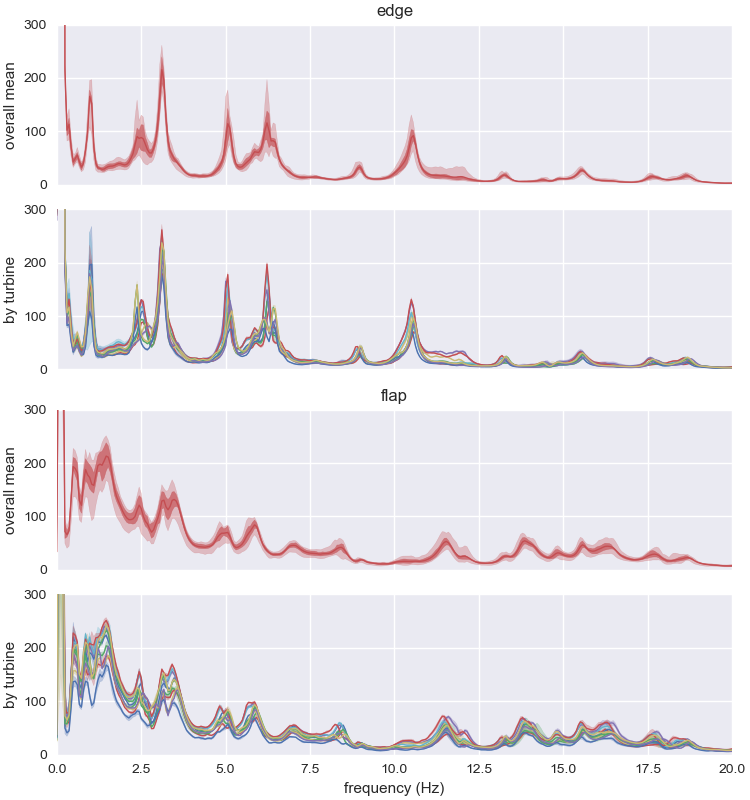

In [1288]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(7.5, 8))

for _ori, _axes in zip(('edge', 'flap'), (axes[:2], axes[2:])):
    _data = means.loc[:, means.columns.get_level_values('channel').str.endswith(_ori[-3:])]

    ax = plots.quantileband(_data.groupby(level=0, axis=1).mean(), amin=0.3, ax=_axes[0])

    for _db, _grp in _data.groupby(level=0, axis=1):
        ax = plots.quantileband(_grp, [1], amin=0.3, label=_db, ax=_axes[1])

    ax.set_ylabel('by turbine')
    _axes[0].set_ylabel('overall mean')
    _ = _axes[0].set_title(_ori)
    
_ = axes[-1].set_xlabel('frequency (Hz)')

In [1291]:
_ = axes[-1].set_xlim(0, 20)
_ = axes[-1].set_ylim(0, 300)

In [1267]:
weasts = []
for _db in means.columns.get_level_values(0).unique():
    _where = opstate.copy()
    _where['create_time'] = data_periods[_db].aswhere
    weasts.append(weadbs.cdef_query(_db, cycle='hour', where=_where))
    
weasts = pd.concat(weasts, keys=means.columns.get_level_values(0).unique())

u:\wms-python\wms\dbs\select.py:226: UserWarning: Discarding nonzero nanoseconds in conversion
  constraint = tuple(cfun(c) for c in constraint[:2])


<IPython.core.display.Javascript object>


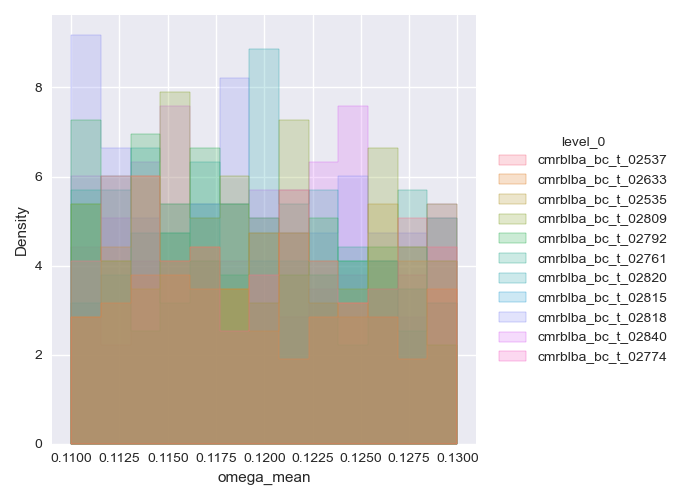

In [1282]:
sns.displot(weasts.omega_mean.reset_index(), 
            x='omega_mean', hue='level_0', stat='density', element='step')

## Find peaks which move linarly with omega (drive train dependents)

In [444]:
class OmegaSpectrogram(bchdf.Loader):
    def __init__(self, omega_bins, *args, opstate=None, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.omega_bins = omega_bins
        self.opstate = {} if opstate is None else opstate
        
    def _convert(self, data):
        where = self.opstate.copy()
        where['create_time'] = (data.index[0],
                                data.index[-1] + pd.Timedelta(seconds=1))
        st = weadbs.cdef_query(
            'cmrblba_' + self.db_name, cycle='hour',
            where=where, columns=['create_time', 'omega_mean'])
        st = st.set_index('create_time').tz_localize(self.origin_tz, ambiguous='NaT')
        
        cts = st.index.intersection(data.index)
        data = data.loc[cts]
        st = st.loc[cts]
        
        grp = data.groupby(pd.cut(st.omega_mean, self.omega_bins))
        
        return grp.sum(), grp.size()
    
    def _combine(self, result):
        if not result:
            return pd.DataFrame([], dtype=float)
        
        sums, N = result[0]
        for _sums, _N in result[1:]:
            sums += _sums
            N += _N
            
        return sums.divide(N, axis=0)

In [514]:
omload = OmegaSpectrogram(
    np.arange(0.05, 0.23, 0.005), 'af', hdfdir / dbs[1][8:], opstate={'omega_sigma': (0, 1)})

In [515]:
omspec, _ticks, _cts = omload.load(data_periods[dbs[1]].aswhere, channels='blades')

u:\bchdf\bchdf\bchdf.py:623: UserWarning: Discarding nonzero nanoseconds in conversion
  params = tuple(pd.Timestamp(ts).to_pydatetime() for ts in params)


loading ... 100% done.
combining data ... done.


In [834]:
chform = bchdf.chnames.recognise_chform('Sensor.Blade#3.Flap')

def spectrogram(omspec, slopes=None, **kwargs):
    fig, ax = plt.subplots(constrained_layout=True)
    
    chs = omspec.columns.get_level_values('channel').unique()
    meanspec = omspec[chs[0]]
    for ch in chs[1:]:
        meanspec += omspec[ch]
    meanspec /= chs.size
    
    freqs = np.r_[meanspec.columns, 
                  meanspec.columns[-1] + meanspec.columns[1]]
    om = np.r_[meanspec.index.categories.left, 
               meanspec.index.categories.right[-1]]

    mesh = ax.pcolormesh(om, freqs, np.log(meanspec.T), **kwargs)

    ax.set_ylabel('frequency (Hz)')
    ax.set_xlabel('omega (Hz)')
    fig.colorbar(mesh, ax=ax)
    
    if slopes is not None:
        if np.isscalar(slopes):
            slopes = [slopes]
        
        xl = np.array(ax.get_xlim())
        ax.set_autoscale_on(False)
        for slope in slopes:
            ax.plot(xl, slope * xl, label=f'{slope:.0f}', lw=1)
    
    return ax

In [528]:
axes[0].set_yscale('linear')
axes[0].set_ylim(0, 500)

(0.0, 500.0)

In [632]:
lines = [[[0.0925, 268], [0.1575, 460]],
         [[0.1, 235], [0.16, 375]],
         [[0.09, 160], [0.17, 300]],
         [[0.09, 105], [0.18, 210]],
         [[0.09, 53], [0.18, 106]]]

In [633]:
def estimate(line):
    m = (line[1][1] - line[0][1]) / (line[1][0] - line[0][0])
    b = line[0][1] - m * line[0][0]
    
    return m, b

In [634]:
lines = [estimate(line) for line in lines]

In [635]:
lines

[(2953.846153846154, -5.230769230769226),
 (2333.3333333333335, 1.6666666666666288),
 (1749.9999999999998, 2.5000000000000284),
 (1166.6666666666667, 0.0),
 (588.8888888888889, 0.0)]

In [527]:
#fig, ax = plt.subplots()
_x = np.array([0, 0.22])
for ax in axes:
    for line in lines:
        ax.plot(_x, line(_x))

In [498]:
importlib.reload(hdf5)

<module 'wms.dbs.hdf5' from 'u:\\wms-python\\wms\\dbs\\hdf5.py'>

In [499]:
sploader = hdf5.FilterLoader(
    {'omega_mean': (0.08,), 'omega_sigma': (0, 0.5)}, 
    'af', hdfdir / dbs[1][8:])

In [500]:
specs, _ticks, _cts = sploader.load(data_periods[dbs[1]].aswhere, channels='blades')

loading ... 100% done.
combining data ... done.


In [733]:
mspecsed.agg_freq(_ticks[:300].set_names('start_f')).se

channel                        1_edge                                          \
start_f                     0.000000     0.061035     0.122070      0.183105    
2019-03-12 21:51:06+01:00   96.124687   276.187531  3987.149170  11144.409180   
2019-03-15 05:36:50+01:00   79.692184   199.166977  4513.223145  11140.395508   
2019-03-15 09:45:36+01:00   82.204086   217.692017  4405.638672  11126.905273   
2019-03-16 15:41:59+01:00  103.493591   264.043854  3996.046143  11120.327148   
2019-03-18 07:46:02+01:00  100.112396   260.263458  3923.636719  10966.742188   
...                               ...          ...          ...           ...   
2020-06-01 05:33:39+02:00  294.448853  3145.789307  9253.724609   6505.851074   
2020-06-01 06:50:05+02:00  308.254242  3177.091553  9426.388672   6674.021484   
2020-06-02 03:37:31+02:00  301.700012  3214.672119  9520.718750   6737.284668   
2020-06-02 07:46:16+02:00  561.208923  4861.640625  6801.737793   2265.748047   
2020-06-02 20:49:25+02:00  645.241760  4812.268066  6346.204590   1955.676270   

channel                                                                     \
start_f                      0.244141    0.305176    0.366211    0.427246    
2019-03-12 21:51:06+01:00  7532.377441  612.494080  265.076019  167.696732   
2019-03-15 05:36:50+01:00  6789.314453  374.792725  319.196014  253.651932   
2019-03-15 09:45:36+01:00  6916.050293  395.036835  267.294830  212.406754   
2019-03-16 15:41:59+01:00  7495.445801  601.323853  385.402588  374.060577   
2019-03-18 07:46:02+01:00  7412.230957  578.906677  250.794601  195.464661   
...                                ...         ...         ...         ...   
2020-06-01 05:33:39+02:00   558.502625  124.684166   52.561203   51.415466   
2020-06-01 06:50:05+02:00   584.057861  130.710007   48.181183   38.062717   
2020-06-02 03:37:31+02:00   601.166321  152.332092   66.371918   47.581715   
2020-06-02 07:46:16+02:00   184.688782   75.714165   64.293861   70.897697   
2020-06-02 20:49:25+02:00   180.727005   54.962513   26.832132   18.157183   

channel                                            ...                        \
start_f                     0.488281    0.549316   ...  17.700195  17.761230   
2019-03-12 21:51:06+01:00   92.378235   77.881981  ...  43.958252  39.349720   
2019-03-15 05:36:50+01:00  105.335213  102.787048  ...  40.736683  47.159500   
2019-03-15 09:45:36+01:00  110.608849  122.945953  ...  45.462433  42.519436   
2019-03-16 15:41:59+01:00  129.909836  114.843178  ...  56.958801  51.480480   
2019-03-18 07:46:02+01:00   84.456200   83.058510  ...  27.807884  28.004499   
...                               ...         ...  ...        ...        ...   
2020-06-01 05:33:39+02:00   50.111385   75.216316  ...   7.744566   7.317133   
2020-06-01 06:50:05+02:00   53.905224   86.042076  ...   8.120000   7.466400   
2020-06-02 03:37:31+02:00   92.001427  134.676743  ...  16.054817  13.406734   
2020-06-02 07:46:16+02:00  100.037132   99.976524  ...  10.009383  12.264216   
2020-06-02 20:49:25+02:00   16.202333   12.814183  ...   3.282500   2.785817   

channel                                                                \
start_f                    17.822266  17.883301  17.944336  18.005371   
2019-03-12 21:51:06+01:00  55.106434  49.699783  47.786549  46.941700   
2019-03-15 05:36:50+01:00  51.683014  39.742466  39.250385  40.084030   
2019-03-15 09:45:36+01:00  48.401234  38.249981  44.656399  46.997746   
2019-03-16 15:41:59+01:00  49.494183  47.101246  39.684418  40.627369   
2019-03-18 07:46:02+01:00  27.974548  23.329750  26.467718  39.089085   
...                              ...        ...        ...        ...   
2020-06-01 05:33:39+02:00   5.382416   6.954283   6.122000   5.088050   
2020-06-01 06:50:05+02:00   8.308367   8.339466   6.158833   6.232200   
2020-06-02 03:37:31+02:00  13.432733  12.552283  12.477567  12.444934   
2020-06-02 07:46:16+02:00  11.607533  13.802951  14.888883  13.686433   
2020-06-02 20:

In [506]:
st = weadbs.cdef_query(
    dbs[1], cycle='hour', where={'create_time': set(specs.index)},
    columns=['create_time', 'omega_mean', 'omega_sigma', 'power_mean', 'power_sigma',
             'pitch_mean', 'pitch_sigma', 'wind_mean', 'wind_sigma'])
st = st.set_index(['create_time']).tz_localize(sploader.origin_tz)

In [616]:
_chs = specs.columns.get_level_values('channel').unique()
meanspecs = specs[_chs[0]]
for _ch in _chs[1:]:
    meanspecs += specs[_ch]
meanspecs /= _chs.size
mspecsed = weadbs.SEData(
    pd.concat([meanspecs], axis=1, keys=pd.Index(['1_edge'], name='channel')),
    st)

In [623]:
mspecsed.se.droplevel('channel', axis=1)

start_f,0.000000,0.061035,0.122070,0.183105,0.244141,0.305176,0.366211,0.427246,0.488281,0.549316,...,499.389648,499.450684,499.511719,499.572754,499.633789,499.694824,499.755859,499.816895,499.877930,499.938965
2019-03-12 21:51:06+01:00,96.124687,276.187531,3987.149170,11144.409180,7532.377441,612.494080,265.076019,167.696732,92.378235,77.881981,...,1.479050,1.576417,1.637767,1.569817,2.138850,1.784350,1.893183,1.568950,1.247733,1.593500
2019-03-15 05:36:50+01:00,79.692184,199.166977,4513.223145,11140.395508,6789.314453,374.792725,319.196014,253.651932,105.335213,102.787048,...,2.977067,2.700617,3.072383,3.679733,2.931883,2.730533,3.081767,2.759867,2.606983,2.189250
2019-03-15 09:45:36+01:00,82.204086,217.692017,4405.638672,11126.905273,6916.050293,395.036835,267.294830,212.406754,110.608849,122.945953,...,2.455267,2.498017,2.459750,3.061417,2.728450,2.746367,2.764917,2.781333,3.090983,2.687516
2019-03-16 15:41:59+01:00,103.493591,264.043854,3996.046143,11120.327148,7495.445801,601.323853,385.402588,374.060577,129.909836,114.843178,...,2.338500,1.548833,1.658667,1.574950,1.681567,1.409150,1.232317,1.377900,1.566233,1.297117
2019-03-18 07:46:02+01:00,100.112396,260.263458,3923.636719,10966.742188,7412.230957,578.906677,250.794601,195.464661,84.456200,83.058510,...,1.082267,1.027400,1.219917,1.168150,1.113917,0.994517,1.073867,0.945283,0.797083,0.808800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01 05:33:39+02:00,294.448853,3145.789307,9253.724609,6505.851074,558.502625,124.684166,52.561203,51.415466,50.111385,75.216316,...,0.998817,1.071117,0.931817,1.189967,1.206833,1.135900,1.127950,1.089617,1.025267,1.093817
2020-06-01 06:50:05+02:00,308.254242,3177.091553,9426.388672,6674.021484,584.057861,130.710007,48.181183,38.062717,53.905224,86.042076,...,1.071600,1.152933,1.111450,1.135767,1.235783,1.053400,1.132150,1.084533,1.131250,1.035667
2020-06-02 03:37:31+02:00,301.700012,3214.672119,9520.718750,6737.284668,601.166321,152.332092,66.371918,47.581715,92.001427,134.676743,...,0.927200,0.873950,0.892300,0.960100,0.902750,0.908300,0.961733,1.218950,1.183033,0.898050
2020-06-02 07:46:16+02:00,561.208923,4861.640625,6801.737793,2265.748047,184.688782,75.714165,64.293861,70.897697,100.037132,99.976524,...,0.999733,0.992017,1.127600,0.975017,1.121567,1.037517,0.990533,0.883000,0.838017,0.860133


In [1188]:
import scipy.optimize

class DrivetrainEstimator():
    @property
    def _current_params(self):
        params = dict(amp=self.default_amp,
                      slope=self.default_slope,
                      relwidth=self.default_relwidth)
        
        if hasattr(self, 'optres_'):
            for i, name in enumerate(self.init_):
                params[name] = self.optres_.x[i]
        
        return params['amp'], params['slope'], params['relwidth']
    
    def __init__(self, logamp=True, default_amp=4, default_slope=2000, default_relwidth=1/20):
        self.logamp = logamp
        self.default_amp = default_amp
        self.default_slope = default_slope
        self.default_relwidth = default_relwidth
    
    def fit_specs(self, specsed, fbands=None, channel=None, init=None):
        if fbands is not None:
            specsed = specsed.agg_freq(fbands, start_f=True)
        
        specs = specsed.se[specsed.se.columns[0][0] if channel is None else channel]
        specs.index = specsed.st.omega_mean
        specs = specs.stack()
        
        omf = np.c_[specs.index.get_level_values('omega_mean'),
                    specs.index.get_level_values('start_f')]

        specs = specs.to_numpy()
        if self.logamp:
            specs = np.log(specs)

        return self.fit(omf, specs, init)
    
    def fit(self, omf, amps, init=None):
        if init is None:
            if hasattr(self, 'optres_'):
                del self['optres_']
                del self['init_']
                
            return self
        
        self.init_ = init
        
        if 'amp' in init and 'slope' in init and 'relwidth' in init:
            params = np.r_[init['amp'], init['slope'], init['relwidth']]
            def resids(x):
                return amps - self._evaluate(omf, *x)
            def jac(x):
                return -self._jacobian(omf, *x)
        elif 'amp' in init and 'slope' in init:
            params = np.r_[init['amp'], init['slope']]
            def resids(x):
                return amps - self._evaluate(omf, *x, self.default_relwidth)
            def jac(x):
                return -self._jacobian(omf, *x, self.default_relwidth)
        elif 'amp' in init and 'relwidth' in init:
            params = np.r_[init['amp'], init['relwidth']]
            def resids(x):
                return amps - self._evaluate(omf, x[0], self.default_slope, x[1])
            def jac(x):
                return -self._jacobian(omf, x[0], self.default_slope, x[1])
        elif 'slope' in init and 'relwidth' in init:
            params = np.r_[init['slope'], init['relwidth']]
            def resids(x):
                return amps - self._evaluate(omf, self.default_amp, *x)
            def jac(x):
                return -self._jacobian(omf, self.default_amp, *x)
        elif 'amp' in init:
            params = np.r_[init['amp']]
            def resids(x):
                return amps - self._evaluate(
                    omf, x[0], self.default_slope, self.default_relwidth)
            def jac(x):
                return -self._jacobian(
                    omf, x[0], self.default_slope, self.default_relwidth)
        elif 'slope' in init:
            params = np.r_[init['slope']]
            def resids(x):
                return amps - self._evaluate(
                    omf, self.default_amp, x[0], self.default_relwidth)
            def jac(x):
                return -self._jacobian(
                    omf, self.default_amp, x[0], self.default_relwidth)
        elif 'relwidth' in init:
            params = np.r_[init['relwidth']]
            def resids(x):
                return amps - self._evaluate(
                    omf, self.default_amp, self.default_slope, x[0])
            def jac(x):
                return -self._jacobian(
                    omf, self.default_amp, self.default_slope, x[0])
        
        # in a first performance test estimation was a bit faster with
        # the jacobian function than without, but not much (~30 s vs. ~39 s)
        # the found solution was (almost exactly) the same, as expected
        self.optres_ = scipy.optimize.least_squares(resids, params, jac)

        return self
        
    def _jacobian(self, omf, amp, slope, relwidth):
        if hasattr(self, 'init_'):
            names = []
            if 'amp' in self.init_:
                names.append('amp')
            if 'slope' in self.init_:
                names.append('slope')
            if 'relwidth' in self.init_:
                names.append('relwidth')
        else:
            names = ['amp', 'slope', 'relwidth']
            
        relfreq = omf[:, 1] / omf[:, 0]
        relfreqm1 = relfreq / slope - 1
        energy = np.exp(-1 / 2 / relwidth ** 2 * relfreqm1 ** 2)
            
        jac = {}
        for name in names:
            if name == 'amp':
                jac[name] = energy
            elif name == 'slope':
                jac[name] = (amp / relwidth ** 2 / slope ** 2
                             * energy * relfreq * relfreqm1)
            elif name == 'relwidth':
                jac[name] = (amp / relwidth ** 3
                             * energy * relfreqm1 ** 2)
            
        return np.array(list(jac.values())).T
            
    @staticmethod
    def _evaluate(omf, amp, slope, relwidth):
        deviation = omf[:, 1] / (omf[:, 0] * slope) - 1
        
        return amp * np.exp(-0.5 * (deviation / relwidth) ** 2)
        
    def predict(self, omf):
        return self._evaluate(omf, *self._current_params)
    
    def plot(self, omegabins=np.arange(0.05, 0.2, 0.005), 
             freqbins=np.arange(0, 500, 0.1), show_log=True, ax=None, vmin=0, **kwargs):
        
        omg, fg = np.meshgrid((omegabins[0:-1] + omegabins[1:]) / 2, 
                              (freqbins[0:-1] + freqbins[1:]) / 2)

        spec = self.predict(np.c_[omg.flatten(), fg.flatten()]).reshape(omg.shape)
        if show_log:
            if not self.logamp:
                spec = np.log(spec)
        else:
            if self.logamp:
                spec = np.exp(spec)

        if ax is None:
            fig, ax = plt.subplots(constrained_layout=True)
        else:
            fig = ax.get_figure()

        mesh = ax.pcolormesh(omegabins, freqbins, spec, vmin=vmin, **kwargs)
        
        fig.colorbar(mesh, ax=ax)

        return ax
    

class Drivetrain():
    """
    
    Parameters
    ----------
    snrwidth : float
        An assumption about the relative width of a peak described by
        a drive train excitation. The idea here is that the peak induced by
        the drive train goes approximately from f - snrwidth * f to 
        f + snrwidth * f where f is the frequency predicted by the given 
        slope for any particular omega (f = omega * slope). Amplitudes within 
        this frequency band define the peak amplitude. This is then compared
        to the surround amplitude in (f - 3 snrwidth * f, f - snrwidth * f)
        and (f + snrwidth * f, f + 3 snrwidth * f).
        
    """
    @staticmethod
    def _check_hypotheses(hyp):
        if isinstance(hyp, slice):
            return np.arange(hyp.start, hyp.stop, hyp.step)
        elif isinstance(hyp, tuple):
            return np.arange(*hyp)
        elif isinstance(hyp, (np.ndarray, pd.Series)):
            hyp = np.array(hyp)
            if hyp.ndim == 1:
                return hyp
            else:
                raise TypeError("Drivetrain hypotheses must be 1D only!")
        else:
            raise TypeError(f"Usupported Drivetrain hypotheses type: {type(hyp)}!")
            
    @property
    def hypotheses(self):
        return self._hypotheses
    @hypotheses.setter
    def hypotheses(self, hypotheses):
        if not isinstance(hypotheses, list):
            hypotheses = [hypotheses]
        
        self._hypotheses = np.concatenate(
            [self._check_hypotheses(hyp) for hyp in hypotheses])
        
    @property
    def df(self):
        return self._df
    @df.setter
    def df(self, df):
        if np.isscalar(df):
            df = {(0, 500): df}
        
        high = 0
        for band, _df in df.items():
            assert np.isreal(df)
            assert len(band) == 2
            assert band[0] >= high and band[1] > high and band[1] <= 500
            high = band[1]
        
        self._df = pd.Series(df)
        self._df.index = pd.IntervalIndex.from_tuples(
            self._df.index, name='band')
        
    @property
    def bands(self):
        return self.df.index
        
    @staticmethod
    def _frac_overlap(intervals, intv, denom=0):
        right = np.fmax(np.fmin(intervals.right, intv.right), intv.left)
        left = np.fmin(np.fmax(intervals.left, intv.left), intv.right)
    
        if denom:
            return (right - left) / (intv.right - intv.left)
        else:
            return (right - left) / (intervals.right - intervals.left)
    @property
    def hypbands(self):
        hyps = pd.IntervalIndex.from_arrays(
            self.hypotheses * 0.1, self.hypotheses * 0.2)
        
        hypbands = pd.DataFrame(
            [self._frac_overlap(hyps, band) for band in self.bands],
            index=self.bands, columns=self.hypotheses)
        
        return hypbands.idxmax()
    
    def band(self, slope):
        return pd.Series(
            self._frac_overlap(self.bands,
                               pd.Interval(0.1 * slope, 0.2 * slope),
                               denom=1),
            index=self.bands).idxmax()
    
    @property
    def bandhyps(self):
        return self.hypbands.groupby(self.hypbands).groups
    
    @property
    def converged(self):
        if hasattr(self, 'estimators_'):
            slopes = pd.DataFrame(
                {hyp: (self.estimators_[hyp].optres_.x[1],
                       self.estimators_[hyp].optres_.success)
                 for hyp in self.hypotheses 
                 if self.estimators_[hyp] is not None},
                index=['slope', 'success']).T.astype(
                    dict(slope=float, success=bool))
            
            ind = slopes.slope < 100
            slopes.loc[ind, 'slope'] = slopes.loc[ind, 'slope'].round(1)
            ind = slopes.slope >= 100
            slopes.loc[ind, 'slope'] = slopes.loc[ind, 'slope'].round()
            
            return slopes
        else:
            raise TypeError("Cannot retrieve slopes - models not fitted yet!")
        
    def __init__(self, hypotheses=[(1, 19, 2), (20, 1000, 20), (1000, 3001, 200)], 
                 df={(0, 10): None, (10, 50): 0.2, (50, 200): 1, (200, 500): 2},
                 snrwidth=1/50):
        self.hypotheses = hypotheses
        self.df = df
        self.snrwidth = snrwidth
    
    @staticmethod
    def _relSNR(series, slope, relwidth):
        omega = series.name
        
        # ensure that center contains at least one frequency
        df = series.index[1] - series.index[0]
        if omega * 2 * relwidth < df:
            relwidth = df / (omega * 1.9)
        
        centerf = slope * omega * (1 + np.r_[-relwidth, relwidth])
        center = series.loc[slice(*centerf)].mean()
        
        leftf = slope * omega * (1 + np.r_[-3 * relwidth, -relwidth])
        left = series.loc[slice(*leftf)].mean()
        
        rightf = slope * omega * (1 + np.r_[relwidth, 3 * relwidth])
        right = series.loc[slice(*rightf)].mean()
        
        surround = (left + right) / 2
        
        return center / surround
        
    def eval_slope(self, specsed, slope,
                   ombins=np.arange(0.08, 0.21, 0.01)):
        """Compute a confidence into a slope for omega bins.
        
        The confidence is given as signal-to-noise ratios in (0, inf).
        Values above ~1.5 are reasonable indication that the slope is
        backed up by the data.
        
        Parameters
        ----------
        specsed : SEData
            Spectra to evaluate slope on. In SEData to have info about
            omega_mean for each cycle / spectrum.
        slope : None, float
            The slope to evaluate. Use the currently stored one, if None.
        ombins : sequence of float
            Omega bins in which to evaluate the slope. Can be anything 
            understood by pd.cut.
        
        Returns
        -------
        snrs : Series
            Relative SNRs for each omega bin. 'relative', because the width
            of the frequency bands defining peak and surround is relative to
            omega.
            
        Notes
        -----
        It is necessary to bin the data by omega for evaluating the slope, 
        because:
        
        1. There are drive train excitations which are only visible in
           certain omega bands. A global confidence measure would be
           rather low, when evaluating across all omega bands for these
           excitations.
        2. Cycles typically occur very unregularly across operational states,
           i.e., some operational states / omegas occur much more frequently
           than others. Simple averaging across all states means that 
           frequent states have a strong influence on the average. E.g.,
           when the SNR in the most frequent state is low, but is high in
           a couple of rare states, the mean SNR would be low.
        """
        meanspecs = self._compute_meanspecs(specsed)
        meanspecs.index = specsed.st.omega_mean
        
        relSNRs = meanspecs.agg(lambda s: self._relSNR(s, slope, self.snrwidth), axis=1)
        
        return relSNRs.groupby(pd.cut(relSNRs.index, ombins)).mean()
    
    @staticmethod
    def _compute_meanspecs(specsed):
        chs = specsed.se.columns.get_level_values('channel').unique()
        meanspecs = specsed.se[chs[0]]
        for ch in chs[1:]:
            meanspecs += specsed.se[_ch]
        meanspecs /= chs.size
        
        return meanspecs
    
    def fit(self, specsed, y=None, verbose=1, initamp=None):
        initamp = pd.Series({(0, 5): 4, (5, 100): 3, (100, 300): 2, (300, 500): 1})
        initamp.index = pd.IntervalIndex.from_tuples(initamp.index)
        
        self.estimators_ = {hyp: None for hyp in self.hypotheses}
        for band, hyps in self.bandhyps.items():
            if verbose:
                print(f'preparing band {band} ...', flush=True)
            
            if pd.isna(self.df[band]):
                fbands = None
            else:
                fbands = np.arange(band.left, band.right, self.df[band])
                
            spsed = specsed.agg_freq(fbands, start_f=True)
            
            meanspecs = self._compute_meanspecs(spsed)
            spsed = weadbs.SEData(
                pd.concat([meanspecs], axis=1, keys=pd.Index(
                    ['1_edge'], name='channel')),
                spsed.st)
            
            for hyp in hyps:
                if verbose:
                    i = np.flatnonzero(self.hypotheses == hyp)[0]
                    print(f'\restimating hypothesis of slope = {hyp:4.0f} '
                          f'({i + 1:3d}/{self.hypotheses.size:3d}) ...', end='', flush=True)
                    
                drest = DrivetrainEstimator(True, 5, 2, 1 / 20)
        
                # need to set good values for relwidth for different bands
        
                drest.fit_specs(spsed, init=dict(
                    amp=initamp.loc[hyp * 0.15], slope=hyp))
                self.estimators_[hyp] = drest
                
            if verbose:
                print('done.')
           
        slopes = self.converged.slope.unique()
            
        self.snrs_ = {}
        for s, slope in enumerate(slopes):
            if verbose:
                print('\revaluating found slope = '
                      f'{slope + 1:6.1f} ({s:2d}/{slopes.size}) ... ',
                      end='', flush=True)
            
            self.snrs_[slope] = self.eval_slope(specsed, slope)
        
        if verbose:
            print('done.')
        
        self.snrs_ = pd.DataFrame(self.snrs_)
        
        return self

In [1189]:
drtr = Drivetrain()

In [1193]:
self = drtr

In [1194]:
slopes = pd.Series([est.optres_.x[1] for est in self.estimators_.values()])

In [1195]:
slopes

0        0.980147
1        4.251921
2        4.933534
3        7.019607
4       10.678827
         ...     
64    2334.900011
65    2335.135583
66    2335.131778
67    2830.185995
68    2829.980309
Length: 69, dtype: float64

<IPython.core.display.Javascript object>


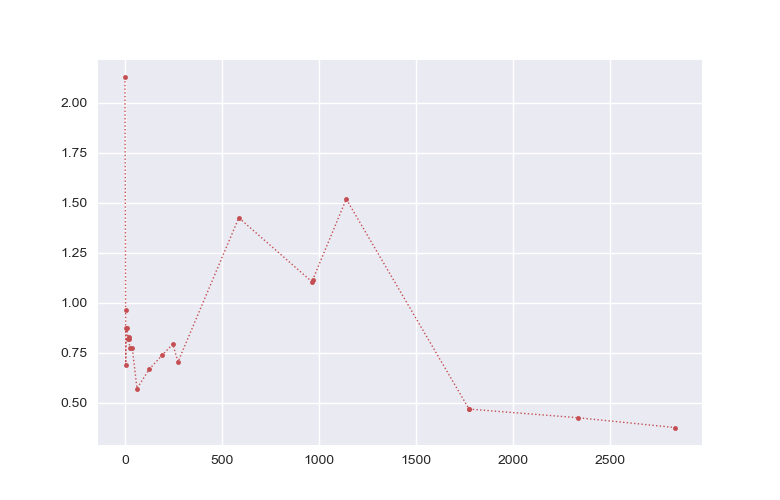

In [1204]:
plt.figure()
drtr.snrs_.mean().plot(style='.:', lw=1)

In [1201]:
drtr.snrs_

,1.0,4.3,4.9,7.0,10.7,17.3,19.4,20.1,25.9,38.4,...,247.0,274.0,587.0,966.0,967.0,1140.0,1772.0,1773.0,2335.0,2830.0
"(0.08, 0.09]",2.169470,0.126049,0.145584,0.241257,0.328065,0.389086,0.366316,0.372279,0.357941,0.351821,...,0.283183,0.256316,0.931282,0.580058,0.578385,0.487302,0.479908,0.479570,0.355074,0.286268
"(0.09, 0.1]",3.153445,0.129487,0.127744,0.189185,0.302256,0.349556,0.344325,0.345678,0.314908,0.323601,...,0.333979,0.306833,0.929783,0.729709,0.729250,0.686804,0.549605,0.546750,0.439530,0.323368
"(0.1, 0.11]",1.882554,0.119868,0.123597,0.207436,0.491287,0.697728,0.668015,0.646060,0.798556,0.773910,...,0.740419,0.658915,1.163367,1.073748,1.072966,0.953309,0.807299,0.807572,0.665026,0.402011
"(0.11, 0.12]",1.972730,0.179215,0.190406,0.395408,1.132202,0.935104,0.752328,0.723169,0.979940,0.772381,...,0.870245,0.694182,1.442344,1.012914,1.011333,0.970499,0.719321,0.718894,0.574364,0.424794
"(0.12, 0.13]",1.991824,0.317158,0.406458,0.943792,1.334765,0.801955,0.741367,0.795447,0.997330,0.755842,...,1.040464,0.656279,1.497427,1.009712,1.009494,1.036462,0.674701,0.674109,0.487524,0.429565
"(0.13, 0.14]",1.928201,0.377927,0.704226,1.143493,1.178829,0.689096,0.803889,0.848875,0.877916,0.781547,...,1.231759,0.801211,1.571093,1.872474,1.878356,1.983288,0.404488,0.403809,0.319607,0.380142
"(0.14, 0.15]",2.026055,1.079118,0.999486,1.087273,1.109234,0.750796,0.930284,0.993377,0.867454,0.879977,...,0.764913,0.621794,1.873820,1.313165,1.333114,1.642804,0.424396,0.423892,0.268303,0.383466
"(0.15, 0.16]",2.642555,1.463926,1.225022,1.010614,1.064133,0.864494,1.075030,1.056945,0.816978,0.935717,...,0.712220,0.729748,1.635276,0.928687,0.962036,1.809655,0.408465,0.407969,0.294952,NaN
"(0.16, 0.17]",1.865358,1.724250,1.289355,1.162518,0.982550,0.968329,1.082110,1.053630,0.834628,0.963498,...,0.803308,0.844110,1.409809,1.090798,1.097507,2.183106,0.346382,0.345960,0.236559,NaN
"(0.17, 0.18]",1.967891,1.757513,1.105676,1.336176,0.902788,1.099991,1.149200,1.107254,0.759546,0.969869,...,0.950135,0.937068,1.449204,1.168072,1.169654,1.894480,0.306871,0.306439,0.336247,NaN


In [1206]:
meanspecs = drtr._compute_meanspecs(specsed)

In [ ]:
spectrogram

In [1207]:
meanspecs

start_f,0.000000,0.061035,0.122070,0.183105,0.244141,0.305176,0.366211,0.427246,0.488281,0.549316,...,499.389648,499.450684,499.511719,499.572754,499.633789,499.694824,499.755859,499.816895,499.877930,499.938965
2019-03-12 21:51:06+01:00,38.114933,118.129486,1410.600586,3942.792725,2655.976807,244.896194,184.329453,145.433029,91.308022,76.922226,...,1.564750,1.628100,1.583500,1.298083,1.818400,1.845017,2.114933,1.397667,1.044633,1.407633
2019-03-15 05:36:50+01:00,25.878754,87.257690,1562.592651,3880.573486,2435.687744,206.708069,269.332153,223.994186,103.379700,95.664909,...,2.982150,2.784966,2.957600,3.915150,2.347200,1.969367,2.564950,3.046317,2.500150,1.922017
2019-03-15 09:45:36+01:00,25.306616,91.761040,1429.442871,3633.732666,2305.703857,153.067093,132.658218,121.363197,79.284607,77.442169,...,1.907383,1.381583,1.408767,2.181900,2.318600,1.934900,1.997483,2.074217,1.806083,1.918600
2019-03-16 15:41:59+01:00,39.479900,96.172874,1289.384155,3535.774170,2367.125732,210.508850,258.951965,271.720306,119.429710,95.890358,...,1.496467,1.078000,1.124750,1.260167,1.490583,1.537300,1.263250,1.000183,1.053200,1.099583
2019-03-18 07:46:02+01:00,37.387638,94.886803,1424.231445,3965.092773,2663.495850,203.727890,154.901138,146.845871,65.767715,36.913380,...,1.086217,1.150183,1.093300,1.112083,0.868917,0.850500,1.010550,0.804400,0.680333,0.478883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01 05:33:39+02:00,113.803680,1200.891724,3524.332764,2475.729004,208.740005,68.813057,32.133915,35.908031,60.108532,109.950409,...,1.361617,1.427350,1.171617,1.654067,1.377267,1.011533,1.250383,1.448500,1.063600,1.116233
2020-06-01 06:50:05+02:00,131.022888,1317.841187,3896.916992,2762.778076,245.511719,50.220455,27.633097,29.903933,65.818169,116.510017,...,1.233117,1.087367,1.369117,0.996683,1.160383,1.187467,1.207533,1.041500,1.023600,1.242567
2020-06-02 03:37:31+02:00,136.050522,1459.565918,4340.197266,3069.459717,264.020142,90.872063,43.392502,43.719418,115.735954,182.006531,...,1.080800,0.938450,0.842467,0.953683,1.076517,0.588083,0.703617,0.813833,0.974650,1.075567
2020-06-02 07:46:16+02:00,174.393906,1728.443848,2407.412842,796.408386,83.126907,49.641159,66.471046,84.679367,136.937668,147.953506,...,1.075617,1.156583,1.628167,1.393000,1.353117,1.309167,1.203283,1.120183,1.254900,1.118583


In [1205]:
specsed

signal energies for channels:
[Sensor.Blade#1.Edge, Sensor.Blade#1.Flap, Sensor.Blade#2.Edge, Sensor.Blade#2.Flap, Sensor.Blade#3.Edge, Sensor.Blade#3.Flap]
from 2019-03-12 21:51:06+01:00 to 2020-06-02 20:49:25+02:00
1916 rows

In [1196]:
slopes = self.converged.slope.unique()

In [1197]:
slopes

array([1.000e+00, 4.300e+00, 4.900e+00, 7.000e+00, 1.070e+01, 1.730e+01,
       1.940e+01, 2.010e+01, 2.590e+01, 3.840e+01, 6.290e+01, 1.260e+02,
       1.920e+02, 2.470e+02, 2.740e+02, 5.870e+02, 9.660e+02, 9.670e+02,
       1.140e+03, 1.772e+03, 1.773e+03, 2.335e+03, 2.830e+03])

In [1199]:
verbose = 1

In [1200]:
        self.snrs_ = {}
        for s, slope in enumerate(slopes):
            if verbose:
                print('\revaluating found slope = '
                      f'{slope:6.1f} ({s:2d}/{slopes.size}) ...',
                      end='', flush=True)
            
            self.snrs_[slope] = self.eval_slope(specsed, slope)
        self.snrs_ = pd.DataFrame(self.snrs_)

evaluating found slope = 2830.0 (22/23) ...

In [1190]:
drtr.fit(weadbs.SEData(specs, st))

preparing band (0, 10] ...
estimating hypothesis of slope =    1 (  1/ 69) ...

KeyboardInterrupt: 

In [1191]:
drtr.estimators_ = estimators_

In [1192]:
drtr.converged

,slope,success
1,1.0,True
3,4.3,True
5,4.9,True
7,7.0,True
9,10.7,True
...,...,...
2200,2335.0,True
2400,2335.0,True
2600,2335.0,True
2800,2830.0,True


In [1187]:
estimators_ = drtr.estimators_

In [1186]:
debug

> c:\users\w012029\appdata\local\continuum\miniconda3\envs\wmsupd\lib\site-packages\pandas\core\series.py(2206)round()
   2204         """
   2205         nv.validate_round(args, kwargs)
-> 2206         result = self._values.round(decimals)
   2207         result = self._constructor(result, index=self.index).__finalize__(
   2208             self, method="round"

ipdb> u
> <ipython-input-1181-dfdb481a5e1b>(276)converged()
    274 
    275             ind = slopes.slope < 100
--> 276             slopes.loc[ind, 'slope'] = slopes.loc[ind, 'slope'].round(1)
    277             ind = slopes.slope >= 100
    278             slopes.loc[ind, 'slope'] = slopes.loc[ind, 'slope'].round()

ipdb> ind
1        True
3        True
5        True
7        True
9        True
        ...  
2200    False
2400    False
2600    False
2800    False
3000    False
Name: slope, Length: 69, dtype: bool
ipdb> slopes.loc[ind, 'slope']
1     0.980147
3      4.25192
5      4.93353
7      7.01961
9      10.6788
11   

In [1184]:
drtr.eval_slope(weadbs.SEData(specs, st), 4)

(0.08, 0.09]    0.125730
(0.09, 0.1]     0.123675
(0.1, 0.11]     0.105227
(0.11, 0.12]    0.164172
(0.12, 0.13]    0.251917
(0.13, 0.14]    0.289968
(0.14, 0.15]    0.923187
(0.15, 0.16]    1.114652
(0.16, 0.17]    1.361012
(0.17, 0.18]    1.630869
(0.18, 0.19]    1.785584
(0.19, 0.2]     1.884528
dtype: float64

In [ ]:
drtr.eval_slope()

In [1092]:
drtr.fit(weadbs.SEData(specs, st))

preparing band (0, 10] ...
estimating hypothesis of slope =   13 (  7/ 69) ...

KeyboardInterrupt: 

In [1111]:
specs

channel                   Sensor.Blade#1.Edge                             \
start_f                            0.000000     0.061035      0.122070     
2019-03-12 21:51:06+01:00          161.478607   456.443512   6823.713379   
2019-03-15 05:36:50+01:00          105.780502   340.709106   7676.732422   
2019-03-15 09:45:36+01:00           85.837700   379.781708   7487.381836   
2019-03-16 15:41:59+01:00          181.544403   455.266693   6854.566406   
2019-03-18 07:46:02+01:00          149.632294   459.780304   6774.287598   
...                                       ...          ...           ...   
2020-06-01 05:33:39+02:00          494.791992  4921.161133  14429.422852   
2020-06-01 06:50:05+02:00          505.689911  4883.904785  14417.907227   
2020-06-02 03:37:31+02:00          470.449188  4825.410645  14321.838867   
2020-06-02 07:46:16+02:00          783.943970  8288.021484  11528.368164   
2020-06-02 20:49:25+02:00         1298.978516  8337.988281  11074.361328   

channel                                                             \
start_f                      0.183105      0.244141     0.305176     
2019-03-12 21:51:06+01:00  19056.462891  12880.124023  1008.905396   
2019-03-15 05:36:50+01:00  19050.980469  11620.278320   530.668884   
2019-03-15 09:45:36+01:00  19032.210938  11842.542969   617.095520   
2019-03-16 15:41:59+01:00  19147.808594  12915.698242   958.476685   
2019-03-18 07:46:02+01:00  19004.589844  12858.181641   979.895325   
...                                 ...           ...          ...   
2020-06-01 05:33:39+02:00  10151.273438    865.888000   191.665894   
2020-06-01 06:50:05+02:00  10219.406250    900.050293   188.102707   
2020-06-02 03:37:31+02:00  10128.988281    893.400513   198.755905   
2020-06-02 07:46:16+02:00   3841.246094    308.942413    94.609497   
2020-06-02 20:49:25+02:00   3408.621094    294.791199    85.591103   

channel                                                                    \
start_f                    0.366211    0.427246    0.488281    0.549316     
2019-03-12 21:51:06+01:00  238.361206  128.347702   94.187599   96.191399   
2019-03-15 05:36:50+01:00  280.088989  238.723206  109.787201  134.685898   
2019-03-15 09:45:36+01:00  210.820297  118.376198  108.470100  191.968994   
2019-03-16 15:41:59+01:00  347.198212  236.328293   77.097702  165.280197   
2019-03-18 07:46:02+01:00  249.817001  124.007202   92.580803  110.040298   
...                               ...         ...         ...         ...   
2020-06-01 05:33:39+02:00   63.203499   64.479698   23.402201   16.730000   
2020-06-01 06:50:05+02:00   60.010601   48.823601   19.490000   23.605101   
2020-06-02 03:37:31+02:00   72.423500   46.344002   57.484200   41.359798   
2020-06-02 07:46:16+02:00   83.027298   18.845699   45.206001   45.349499   
2020-06-02 20:49:25+02:00   43.581699   19.246901   13.341900    8.802900   

channel                    ... Sensor.Blade#3.Flap                        \
start_f                    ...          499.389648 499.450684 499.511719   
2019-03-12 21:51:06+01:00  ...              1.5692     1.5428     1.3803   
2019-03-15 05:36:50+01:00  ...              2.8383     2.6857     2.7496   
2019-03-15 09:45:36+01:00  ...              1.7441     1.3583     1.0780   
2019-03-16 15:41:59+01:00  ...              1.4017     1.0355     1.0784   
2019-03-18 07:46:02+01:00  ...              1.0909     1.1339     1.0199   
...                        ...                 ...        ...        ...   
2020-06-01 05:33:39+02:00  ...              1.4017     1.5019     1.2460   
2020-06-01 06:50:05+02:00  ...              1.2681     1.0706     1.4033   
2020-06-02 03:37:31+02:00  ...              1.0537     0.9655     0.8512   
2020-06-02 07:46:16+02:00  ...              1.1555     1.1897     1.7239   
2020-06-02 20:49:25+02:00  ...              0.6848     0.5237     0.4365   

channel                                                                \
start_f                   499.572754

In [1100]:
drtr.estimators_[5].optres_

 active_mask: array([0., 0.])
        cost: 18576363.186309695
         fun: array([ 3.64060616,  4.77178144,  7.25177097, ..., -0.57349914,
       -0.44654745, -0.34582925])
        grad: array([-1.26536413e-02,  2.52928846e+02])
         jac: array([[-1.38389653e-87,  0.00000000e+00],
       [-5.90283872e-77,  2.03722576e-75],
       [-5.09832114e-67,  3.28176838e-65],
       ...,
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 14
        njev: 14
  optimality: 252.92884629642668
      status: 2
     success: True
           x: array([7.19110877, 4.93355498])

In [1088]:
debug

> <ipython-input-1084-d29e3f1cf8fe>(351)fit()
    349                 fbands = None
    350             else:
--> 351                 fbands = np.arange(band.left, band.right, self.df[band])
    352 
    353             spsed = specsed.agg_freq(fbands, start_f=True)

ipdb> band.left
0
ipdb> band.right
10
ipdb> self.df[band]
nan
ipdb> q


In [1089]:
drtr.df

band
(0, 10]       NaN
(10, 50]      0.2
(50, 200]     1.0
(200, 500]    2.0
dtype: float64

In [1083]:
np.flatnonzero(drtr.hypotheses == 400)

array([28], dtype=int64)

In [1082]:
np.diff(drtr.hypotheses)

array([  2,   2,   2,   2,   2,   2,   2,   2,   3,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200])

In [1053]:
drtr.df

band
(0, 10]       NaN
(10, 50]      0.2
(50, 200]     1.0
(200, 500]    2.0
dtype: float64

In [1055]:
drtr._frac_overlap(drtr.bands, pd.Interval(80 * 0.1, 80 * 0.2), 1)

Float64Index([0.25, 0.75, 0.0, 0.0], dtype='float64')

In [1058]:
drtr.hypbands.head(40)

1        (0, 10]
3        (0, 10]
5        (0, 10]
7        (0, 10]
9        (0, 10]
11       (0, 10]
13       (0, 10]
15       (0, 10]
17       (0, 10]
20       (0, 10]
40       (0, 10]
60       (0, 10]
80      (10, 50]
100     (10, 50]
120     (10, 50]
140     (10, 50]
160     (10, 50]
180     (10, 50]
200     (10, 50]
220     (10, 50]
240     (10, 50]
260     (10, 50]
280     (10, 50]
300     (10, 50]
320     (10, 50]
340    (50, 200]
360    (50, 200]
380    (50, 200]
400    (50, 200]
420    (50, 200]
440    (50, 200]
460    (50, 200]
480    (50, 200]
500    (50, 200]
520    (50, 200]
540    (50, 200]
560    (50, 200]
580    (50, 200]
600    (50, 200]
620    (50, 200]
dtype: interval

In [942]:
drest = DrivetrainEstimator(True, 5, 2, 1 / 10)

In [943]:
drest.eval_slope(mspecsed, 498, ombins=np.arange(0.08, 0.2, 0.01))

(0.08, 0.09]    1.166561
(0.09, 0.1]     0.784423
(0.1, 0.11]     0.884681
(0.11, 0.12]    0.917667
(0.12, 0.13]    1.273113
(0.13, 0.14]    1.534367
(0.14, 0.15]    1.666145
(0.15, 0.16]    1.632505
(0.16, 0.17]    1.852369
(0.17, 0.18]    2.460473
(0.18, 0.19]    1.346964
dtype: float64

In [917]:
drest.eval_slope(mspecsed, 498, ombins=np.arange(0.08, 0.2, 0.01))

(1.1845974772951962,
 (0.08, 0.09]    1.166561
 (0.09, 0.1]     0.784423
 (0.1, 0.11]     0.884681
 (0.11, 0.12]    0.917667
 (0.12, 0.13]    1.273113
 (0.13, 0.14]    1.534367
 (0.14, 0.15]    1.666145
 (0.15, 0.16]    1.632505
 (0.16, 0.17]    1.852369
 (0.17, 0.18]    2.460473
 (0.18, 0.19]    1.346964
 dtype: float64)

In [945]:
drest.eval_slope(mspecsed, 287)

(0.08, 0.09]    1.916944
(0.09, 0.1]     1.867713
(0.1, 0.11]     2.299827
(0.11, 0.12]    1.727957
(0.12, 0.13]    1.529196
(0.13, 0.14]    2.291412
(0.14, 0.15]    1.551642
(0.15, 0.16]    1.763825
(0.16, 0.17]    2.042259
(0.17, 0.18]    2.885039
(0.18, 0.19]    2.902409
(0.19, 0.2]     2.249651
dtype: float64

In [918]:
drest.eval_slope(mspecsed, 320, ombins=np.arange(0.08, 0.2, 0.01))

(1.282232957078505,
 (0.08, 0.09]    0.656520
 (0.09, 0.1]     1.820467
 (0.1, 0.11]     1.026384
 (0.11, 0.12]    0.876090
 (0.12, 0.13]    1.120656
 (0.13, 0.14]    0.929226
 (0.14, 0.15]    0.910379
 (0.15, 0.16]    1.024795
 (0.16, 0.17]    0.918205
 (0.17, 0.18]    1.046219
 (0.18, 0.19]    1.060554
 dtype: float64)

In [765]:
drest.fit_specs(mspecsed, _ticks[:100].set_names('start_f'),
                init=dict(amp=5, slope=8, relwidth=1/10))
drest.optres_

 active_mask: array([0., 0., 0.])
        cost: 117586.59739863421
         fun: array([-0.13990003,  0.91563413,  3.58569152, ..., -0.75543551,
       -0.73748144, -0.90650688])
        grad: array([-2.07475679e+01, -1.75146791e+04, -4.57496887e-03])
         jac: array([[-9.99999997e-01,  0.00000000e+00, -1.83264886e-12],
       [-9.99978659e-01, -5.89308175e-02, -1.46667638e-08],
       [-9.99913683e-01, -2.37025337e-01, -5.93208192e-08],
       ...,
       [-4.84209276e-01, -9.59070047e+02, -2.41347876e-04],
       [-4.76985382e-01, -9.64342358e+02, -2.42674792e-04],
       [-4.69796823e-01, -9.69292273e+02, -2.43920575e-04]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 300
        njev: 239
  optimality: 17514.679093965096
      status: 0
     success: False
           x: array([4.70554622e+00, 3.44611485e-03, 1.36933674e+04])

In [749]:
drest.fit_specs(mspecsed, _ticks[:100].set_names('start_f'),
                init=dict(amp=5, slope=1.5))
drest.optres_

 active_mask: array([0., 0.])
        cost: 1606324.871411933
         fun: array([4.56564617, 5.62107992, 8.29083157, ..., 1.52303362, 1.50699532,
       1.30414379])
        grad: array([-1.62145062e-03,  1.78983358e+02])
         jac: array([[-1.38389653e-87,  0.00000000e+00],
       [-2.24839482e-50,  1.37646793e-47],
       [-1.67300540e-23,  1.38743595e-20],
       ...,
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 30
        njev: 30
  optimality: 178.98335810632852
      status: 2
     success: True
           x: array([10.60323806,  1.2778192 ])

<IPython.core.display.Javascript object>


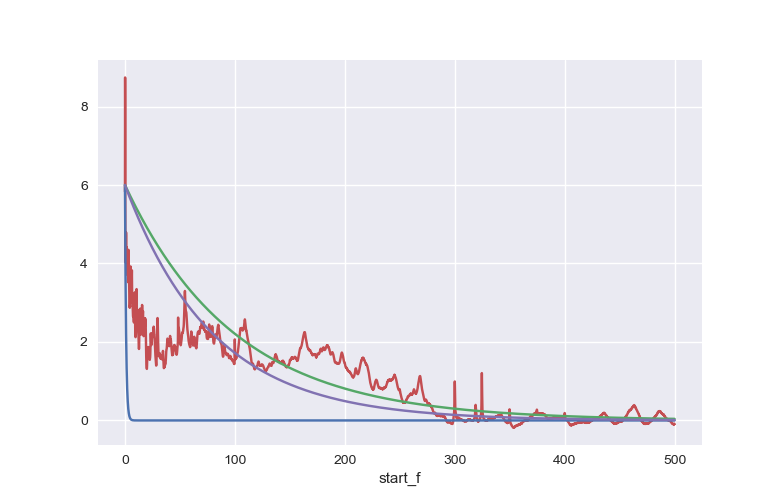

In [1117]:
plt.figure()
ax = np.log(mspecsed.se['1_edge'].loc[:, :500]).mean().plot()

In [1120]:
xx = np.linspace(0, 500, 1000)
ax.plot(xx, 6 * np.exp(-xx / 80))

In [802]:
drest._current_params

(4.9683664737162365, 596.981783421218, 0.05)

In [807]:
drest.default_relwidth = 1 / 50

In [810]:
drest.fit_specs(mspecsed, np.arange(20, 200, 0.5),
                init=dict(amp=3, slope=400))
drest.optres_

 active_mask: array([0., 0.])
        cost: 5378672.5445521595
         fun: array([5.81860733, 5.91291428, 5.69873333, ..., 3.3006351 , 4.02202606,
       3.61033893])
        grad: array([-7.39073329e-03, -8.08475342e+00])
         jac: array([[-3.40905296e-321,  2.05086650e-320],
       [-6.75959313e-316,  4.17354344e-315],
       [-1.21025239e-310,  7.60834962e-310],
       ...,
       [-0.00000000e+000, -0.00000000e+000],
       [-0.00000000e+000, -0.00000000e+000],
       [-0.00000000e+000, -0.00000000e+000]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 154
        njev: 154
  optimality: 8.08475341920996
      status: 2
     success: True
           x: array([  5.99106722, 440.00436125])

<IPython.core.display.Javascript object>


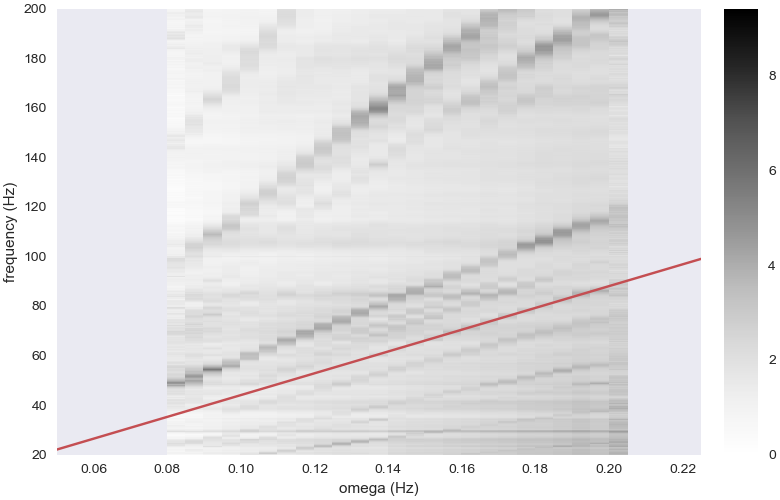

(20.0, 200.0)

In [811]:
specax = spectrogram(_omspec, slopes=[drest._current_params[1]], vmin=0)
specax.set_ylim(20, 200)

In [979]:
200 / 0.2

1000.0

In [818]:
init_slopes = pd.Index(np.arange(200, 520, 20), name='initslope')
optres = pd.Series(dtype=object, index=init_slopes)
for _islope in init_slopes:
    drest.fit_specs(mspecsed, np.arange(20, 200, 0.5),
                    init=dict(amp=3, slope=_islope))
    optres[_islope] = drest.optres_

In [828]:
_res = pd.DataFrame({'amp': optres.map(lambda x: x.x[0]), 'slope': optres.map(lambda x: x.x[1])})

In [921]:
# given a slope estimate the peakiness of the data around the slope line
# for every value of omega
snrs = pd.DataFrame({
    slope: drest.eval_slope(specsed, slope, ombins=np.arange(0.08, 0.2, 0.01))[1]
    for slope in _res.slope.round().unique()})

In [937]:
snrs.mean()

191.0    1.998863
226.0    1.049413
250.0    1.465180
287.0    1.848470
320.0    1.036704
382.0    1.970145
440.0    1.727937
498.0    1.496651
dtype: float64

<IPython.core.display.Javascript object>


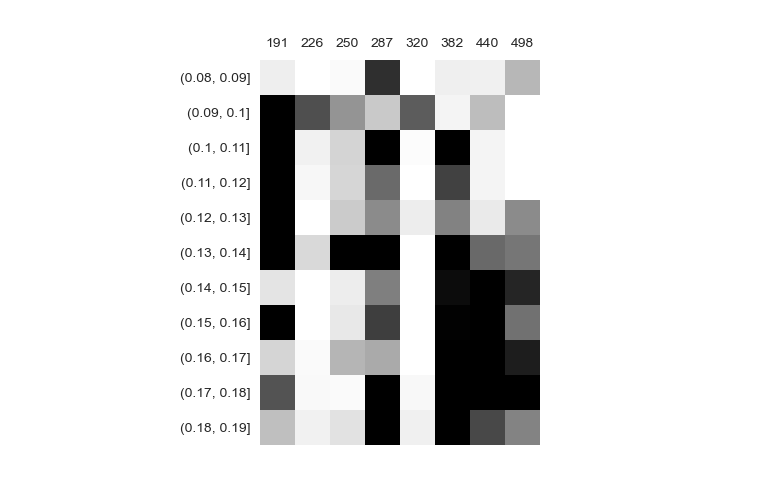

In [936]:
fig, ax = plt.subplots()
ax.matshow(snrs, vmin=1, vmax=2)
ax.grid(False)
ax.set_xticks(np.arange(snrs.shape[1]))
ax.set_xticklabels(snrs.columns.astype(int))
ax.set_yticks(np.arange(snrs.shape[0]))
_ = ax.set_yticklabels(snrs.index)

In [928]:
ax.get_xticklabels()

<a list of 10 Text major ticklabel objects>

In [932]:
ax.get_xticks()

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])

<IPython.core.display.Javascript object>


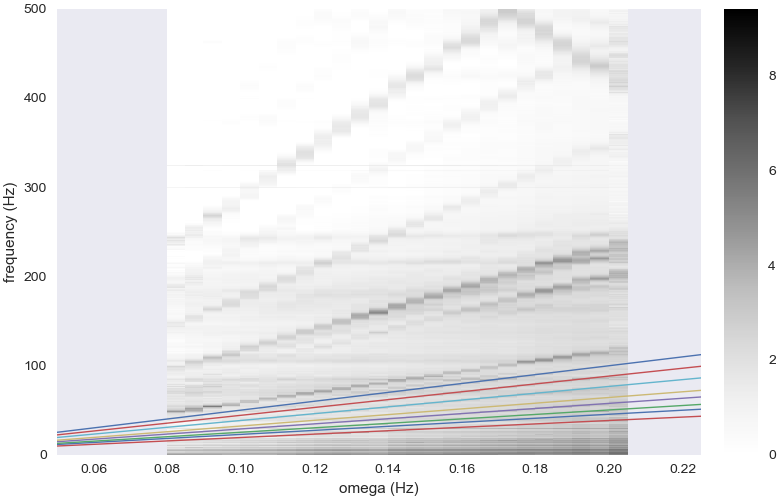

(0.0, 500.0)

In [981]:
specax = spectrogram(_omspec, slopes=_res.slope.round().unique(), vmin=0)
specax.set_ylim(0, 500)

In [1115]:
_omspec

channel       Sensor.Blade#1.Edge                                           \
frequency              0.000000     0.061035      0.122070      0.183105     
omega_mean                                                                   
(0.05, 0.055]                 NaN          NaN           NaN           NaN   
(0.055, 0.06]                 NaN          NaN           NaN           NaN   
(0.06, 0.065]                 NaN          NaN           NaN           NaN   
(0.065, 0.07]                 NaN          NaN           NaN           NaN   
(0.07, 0.075]                 NaN          NaN           NaN           NaN   
(0.075, 0.08]                 NaN          NaN           NaN           NaN   
(0.08, 0.085]         2833.188232  8213.043945   6945.118652    989.117004   
(0.085, 0.09]         2585.013428  8436.583984   7773.580078   1331.102295   
(0.09, 0.095]         2036.377319  8584.028320   8894.027344   1896.540894   
(0.095, 0.1]          1705.254272  8579.583984   9723.662109   2405.756348   
(0.1, 0.105]          1273.494141  8456.004883  10752.072266   3156.576660   
(0.105, 0.11]          909.418396  8200.291016  11693.333984   3992.517578   
(0.11, 0.115]          534.652527  7843.264160  12528.200195   4921.926758   
(0.115, 0.12]          236.255753  7358.882812  13260.809570   5956.531250   
(0.12, 0.125]           67.904388  6839.928223  13833.857422   7004.461426   
(0.125, 0.13]          219.692612  6266.103027  14236.729492   8055.783203   
(0.13, 0.135]          382.013397  5540.073242  14556.899414   9355.655273   
(0.135, 0.14]          470.058167  4915.944824  14586.566406  10340.146484   
(0.14, 0.145]          530.038391  4153.974121  14639.875977  11782.377930   
(0.145, 0.15]          538.859985  3471.325928  14435.911133  12962.127930   
(0.15, 0.155]          507.053955  2896.887695  14142.343750  13969.373047   
(0.155, 0.16]          450.251709  2186.887939  13596.449219  15237.157227   
(0.16, 0.165]          383.571716  1694.682617  13038.369141  16070.098633   
(0.165, 0.17]          283.216278  1126.671753  12202.685547  17031.343750   
(0.17, 0.175]          195.234238   718.444275  11417.803711  17711.976562   
(0.175, 0.18]           92.939217   326.636688  10449.147461  18332.056641   
(0.18, 0.185]           29.137531    97.873825   9532.779297  18708.376953   
(0.185, 0.19]           70.578346   200.700943   8484.564453  18950.943359   
(0.19, 0.195]          137.955185   388.962585   7305.234863  18969.353516   
(0.195, 0.2]           164.718811   451.182281   6752.760742  18914.478516   
(0.2, 0.205]           171.363693   495.209198   5737.018066  18302.689453   
(0.205, 0.21]                 NaN          NaN           NaN           NaN   
(0.21, 0.215]                 NaN          NaN           NaN           NaN   
(0.215, 0.22]                 NaN          NaN           NaN           NaN   
(0.22, 0.225]                 NaN          NaN           NaN           NaN   

channel                                                                       \
frequency        0.244141     0.305176    0.366211    0.427246    0.488281     
omega_mean                                                                     
(0.05, 0.055]           NaN          NaN         NaN         NaN         NaN   
(0.055, 0.06]           NaN          NaN         NaN         NaN         NaN   
(0.06, 0.065]           NaN          NaN         NaN         NaN         NaN   
(0.065, 0.07]           NaN          NaN         NaN         NaN         NaN   
(0.07, 0.075]           NaN          NaN         NaN         NaN         NaN   
(0.075, 0.08]           NaN          NaN         NaN         NaN         NaN   
(0.08, 0.085]    174.835739    63.845631   30.608101   16.889666   20.433699   
(0.085, 0.09]    212.847565    77.435806   35.018227   30.129122   29.336266   
(0.09, 0.095]    263.347504   100.330887   44.173946   29.280287   28.703470   
(0.095, 0.1]     289.409119   118.108597   54.049236   28.721149   29.04346

In [1209]:
drtr.converged.slope.unique()

array([1.000e+00, 4.300e+00, 4.900e+00, 7.000e+00, 1.070e+01, 1.730e+01,
       1.940e+01, 2.010e+01, 2.590e+01, 3.840e+01, 6.290e+01, 1.260e+02,
       1.920e+02, 2.470e+02, 2.740e+02, 5.870e+02, 9.660e+02, 9.670e+02,
       1.140e+03, 1.772e+03, 1.773e+03, 2.335e+03, 2.830e+03])

<IPython.core.display.Javascript object>


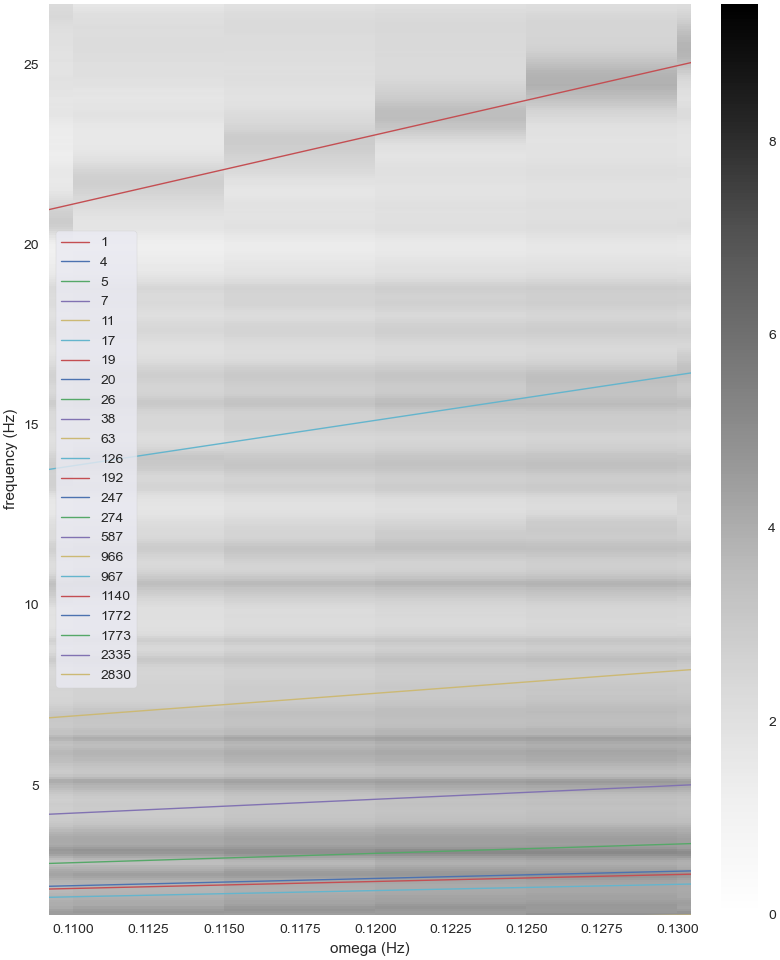

In [1211]:
specax = spectrogram(_omspec, slopes=drtr.converged.slope.unique(), vmin=0)
specax.set_ylim(0, 500)
specax.legend()

In [1258]:
pd.Series(drtr.converged.slope.unique() * 0.12)

0       0.120
1       0.516
2       0.588
3       0.840
4       1.284
5       2.076
6       2.328
7       2.412
8       3.108
9       4.608
10      7.548
11     15.120
12     23.040
13     29.640
14     32.880
15     70.440
16    115.920
17    116.040
18    136.800
19    212.640
20    212.760
21    280.200
22    339.600
dtype: float64

In [1215]:
slope = 1773

In [1217]:
st.omega_mean.iloc[0]

0.19579

In [ ]:
def fmax(f):
    

In [1221]:
meanspecs

start_f,0.000000,0.061035,0.122070,0.183105,0.244141,0.305176,0.366211,0.427246,0.488281,0.549316,...,499.389648,499.450684,499.511719,499.572754,499.633789,499.694824,499.755859,499.816895,499.877930,499.938965
2019-03-12 21:51:06+01:00,38.114933,118.129486,1410.600586,3942.792725,2655.976807,244.896194,184.329453,145.433029,91.308022,76.922226,...,1.564750,1.628100,1.583500,1.298083,1.818400,1.845017,2.114933,1.397667,1.044633,1.407633
2019-03-15 05:36:50+01:00,25.878754,87.257690,1562.592651,3880.573486,2435.687744,206.708069,269.332153,223.994186,103.379700,95.664909,...,2.982150,2.784966,2.957600,3.915150,2.347200,1.969367,2.564950,3.046317,2.500150,1.922017
2019-03-15 09:45:36+01:00,25.306616,91.761040,1429.442871,3633.732666,2305.703857,153.067093,132.658218,121.363197,79.284607,77.442169,...,1.907383,1.381583,1.408767,2.181900,2.318600,1.934900,1.997483,2.074217,1.806083,1.918600
2019-03-16 15:41:59+01:00,39.479900,96.172874,1289.384155,3535.774170,2367.125732,210.508850,258.951965,271.720306,119.429710,95.890358,...,1.496467,1.078000,1.124750,1.260167,1.490583,1.537300,1.263250,1.000183,1.053200,1.099583
2019-03-18 07:46:02+01:00,37.387638,94.886803,1424.231445,3965.092773,2663.495850,203.727890,154.901138,146.845871,65.767715,36.913380,...,1.086217,1.150183,1.093300,1.112083,0.868917,0.850500,1.010550,0.804400,0.680333,0.478883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01 05:33:39+02:00,113.803680,1200.891724,3524.332764,2475.729004,208.740005,68.813057,32.133915,35.908031,60.108532,109.950409,...,1.361617,1.427350,1.171617,1.654067,1.377267,1.011533,1.250383,1.448500,1.063600,1.116233
2020-06-01 06:50:05+02:00,131.022888,1317.841187,3896.916992,2762.778076,245.511719,50.220455,27.633097,29.903933,65.818169,116.510017,...,1.233117,1.087367,1.369117,0.996683,1.160383,1.187467,1.207533,1.041500,1.023600,1.242567
2020-06-02 03:37:31+02:00,136.050522,1459.565918,4340.197266,3069.459717,264.020142,90.872063,43.392502,43.719418,115.735954,182.006531,...,1.080800,0.938450,0.842467,0.953683,1.076517,0.588083,0.703617,0.813833,0.974650,1.075567
2020-06-02 07:46:16+02:00,174.393906,1728.443848,2407.412842,796.408386,83.126907,49.641159,66.471046,84.679367,136.937668,147.953506,...,1.075617,1.156583,1.628167,1.393000,1.353117,1.309167,1.203283,1.120183,1.254900,1.118583


In [1223]:
_f = st.omega_mean.iloc[0] * _slope

In [1245]:
from wms.dbs import csv

In [1249]:
at = csv.load_at('cmrblba_bc_t_01259', '2020-08-04 14:49:47', channels=[3, 4, 5])

In [1251]:
at.std()

channel
3    51.312011
4    51.735870
5    51.804351
dtype: float64

<IPython.core.display.Javascript object>


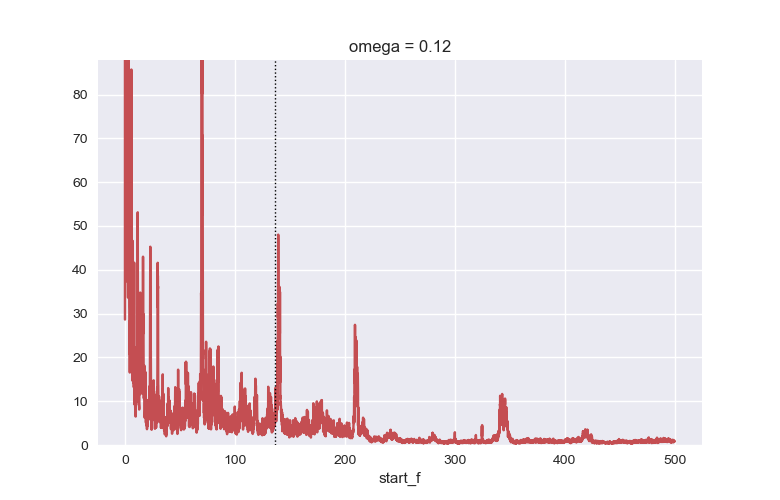

In [1242]:
_slope = 1140
_cyc = 5
_f = st.omega_mean.iloc[_cyc] * _slope

plt.figure()
ax = meanspecs.iloc[_cyc, :].plot()
_ = ax.axvline(_f, lw=1, ls=':', color='k')

ax.set_title(f'omega = {st.omega_mean.iloc[_cyc]:.2f}')
_ = ax.set_ylim(0, meanspecs[meanspecs.columns[np.argmin(np.abs(meanspecs.columns - _f))]].max())

In [1244]:
136 * (1 + np.r_[-1/50, 1/50])

array([133.28, 138.72])

In [1236]:
msp = meanspecs.copy()
msp.index = st.omega_mean

In [1237]:
drtr._relSNR(msp.iloc[_cyc], _slope, drtr.snrwidth)

0.7394053831412483

In [1214]:
drtr.snrs_.loc[:, 1000:]

,1140.0,1772.0,1773.0,2335.0,2830.0
"(0.08, 0.09]",0.487302,0.479908,0.479570,0.355074,0.286268
"(0.09, 0.1]",0.686804,0.549605,0.546750,0.439530,0.323368
"(0.1, 0.11]",0.953309,0.807299,0.807572,0.665026,0.402011
"(0.11, 0.12]",0.970499,0.719321,0.718894,0.574364,0.424794
"(0.12, 0.13]",1.036462,0.674701,0.674109,0.487524,0.429565
"(0.13, 0.14]",1.983288,0.404488,0.403809,0.319607,0.380142
"(0.14, 0.15]",1.642804,0.424396,0.423892,0.268303,0.383466
"(0.15, 0.16]",1.809655,0.408465,0.407969,0.294952,NaN
"(0.16, 0.17]",2.183106,0.346382,0.345960,0.236559,NaN
"(0.17, 0.18]",1.894480,0.306871,0.306439,0.336247,NaN


<IPython.core.display.Javascript object>


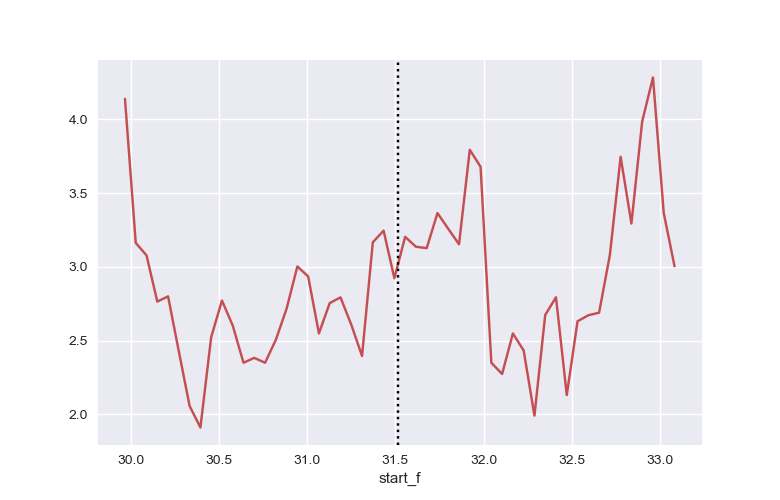

In [876]:
_slope = 382
_omlim = np.r_[0.14, 0.145] + -0.06
_flim = _omlim.mean() * _slope * (1 + np.r_[-1/20, 1/20])

plt.figure()
ax = mspecsed.select_st({'omega_mean': tuple(_omlim)}).se['1_edge'].loc[:, slice(*_flim)].mean().plot()
ax.axvline(_omlim.mean() * _slope, color='k', ls=':')

In [877]:
2 / 104

0.019230769230769232

In [851]:
_slope = 382

_flim = 0.115 * _slope * (1 + np.r_[-1/20, 1/20])

In [852]:
_flim

array([41.7335, 46.1265])

In [919]:
optres

initslope
200    {'x': [6.918701994175609, 191.39353876765324],...
220    {'x': [5.556924208327074, 226.07635374659537],...
240    {'x': [6.04086500796637, 249.81404905615636], ...
260    {'x': [6.040263110084857, 249.86245801975437],...
280    {'x': [6.367321072994467, 286.72420053224334],...
300    {'x': [6.366643474322284, 286.76435857450224],...
320    {'x': [5.577396583171985, 320.40143947459785],...
340    {'x': [6.038604234165861, 382.04786189961186],...
360    {'x': [6.0386102782910696, 382.04638850401], '...
380    {'x': [6.038619566452097, 382.0441167690591], ...
400    {'x': [5.991067215304163, 440.00436124698257],...
420    {'x': [5.991069917803757, 440.0038248022267], ...
440    {'x': [5.991019352295766, 440.01380591009547],...
460    {'x': [6.089539933523363, 498.0712681179546], ...
480    {'x': [6.089539848332659, 498.07128656614594],...
500    {'x': [6.088623910454484, 498.2609363838957], ...
dtype: object

In [843]:
optres.map(lambda x: x.cost)

initslope
200    5.459183e+06
220    5.457342e+06
240    5.438975e+06
260    5.438975e+06
280    5.415869e+06
300    5.415869e+06
320    5.430018e+06
340    5.395114e+06
360    5.395114e+06
380    5.395114e+06
400    5.378673e+06
420    5.378673e+06
440    5.378672e+06
460    5.355441e+06
480    5.355441e+06
500    5.355441e+06
dtype: float64

In [840]:
optres.map(lambda x: x.success)

initslope
200     True
220    False
240     True
260     True
280     True
300     True
320     True
340     True
360     True
380     True
400     True
420     True
440     True
460     True
480     True
500     True
dtype: bool

In [842]:
optres[320]

 active_mask: array([0., 0.])
        cost: 5430018.369921816
         fun: array([5.81860733, 5.91291428, 5.69873333, ..., 3.3006351 , 4.02202606,
       3.61033893])
        grad: array([-9.63171413e-03, -1.04935049e+01])
         jac: array([[-4.13045638e-253,  3.89943526e-252],
       [-1.14003603e-246,  1.09169210e-245],
       [-2.59768317e-240,  2.52092818e-239],
       ...,
       [-0.00000000e+000, -0.00000000e+000],
       [-0.00000000e+000, -0.00000000e+000],
       [-0.00000000e+000, -0.00000000e+000]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 39
        njev: 39
  optimality: 10.493504894680772
      status: 2
     success: True
           x: array([  5.57739658, 320.40143947])

In [812]:
40 / 0.2

200.0

In [814]:
500 * 0.2

100.0

In [816]:
np.arange(200, 520, 20) * 0.2

array([ 40.,  44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,
        84.,  88.,  92.,  96., 100.])

In [844]:
drest.optres_ = optres[320]

<IPython.core.display.Javascript object>


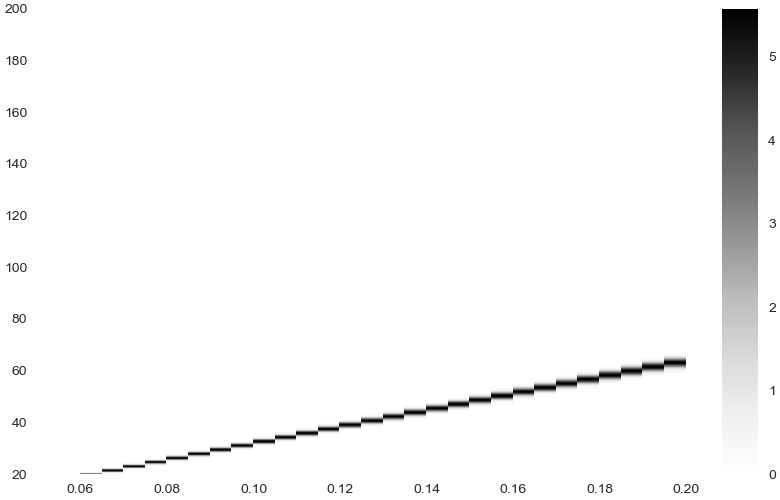

(20.0, 200.0)

In [847]:
ax = drest.plot()
ax.set_ylim(20, 200)